# Clothing Articles Classification

## Imports

In [ ]:
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 
from shutil import copyfile
import numpy as np
import glob
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, Lambda, Input
from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.applications import mobilenet_v2, nasnet
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from tqdm import tqdm

## Data Preparation and Loading

### Data Splitting

In [ ]:
train_dir = 'data/train'
test_dir = 'data/test'
batch_size = 32

In [ ]:
# images_list = glob.glob('/media/user/x_2/img/*/*.jpg')
# random.seed(42)
# random.shuffle(images_list)
# #take only 10% of the images
# images_list = images_list[:int(0.1*len(images_list))]
# #take 90% as train
# train_list = images_list[:int(0.9 *len(images_list))]
# #take 10% as train
# test_list = images_list[int(0.9 *len(images_list)):]

# for mode, list_ in zip(['train', 'test'], [train_list, test_list]):
#   for index, image_path in enumerate(list_):
#     image_path_splitted = image_path.split(os.sep)
#     category = image_path_splitted[-2].split('_')[-1]
#     filename = image_path_splitted[-1]
#     category_path = os.path.join('data', mode, category)
#     if not os.path.exists(category_path):
#       os.makedirs(category_path, exist_ok=True)
#     copyfile(image_path, category_path + '/' + str(index)+'_'+filename)

In [ ]:
#!rm -rf img/Striped_A-Line_Dress && mv img/Striped_A-line_Dress img/Striped_A-Line_Dress

### Number of instances per class (Data Imbalance)

In [ ]:
instances_per_class = {}
for category in sorted(glob.glob(train_dir+'/*')):
    instances_per_class[category.split('/')[-1]] = len(next(os.walk(category))[2])
df = pd.DataFrame.from_dict(instances_per_class,orient='index',columns=['count'])
df

,count
Anorak,18
Blazer,687
Blouse,2183
Bomber,25
Button-Down,39
Caftan,3
Capris,9
Cardigan,1163
Chinos,29
Coat,199


### Data Augmentation and Loading from directory

In [ ]:
train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.1)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training',
        seed=42
        )


val_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='validation',
        classes = list(train_generator.class_indices.keys()),
        seed=42
        )

test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=1,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical',
        classes = list(train_generator.class_indices.keys()),
        seed=42
        )


Found 23448 images belonging to 46 classes.
Found 2580 images belonging to 46 classes.
Found 2893 images belonging to 46 classes.


### Class weighting to fix the data imbalance problem

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(train_generator.classes),
                                                  y= train_generator.classes)
class_weights = dict(enumerate(class_weights))

### Data Visualization

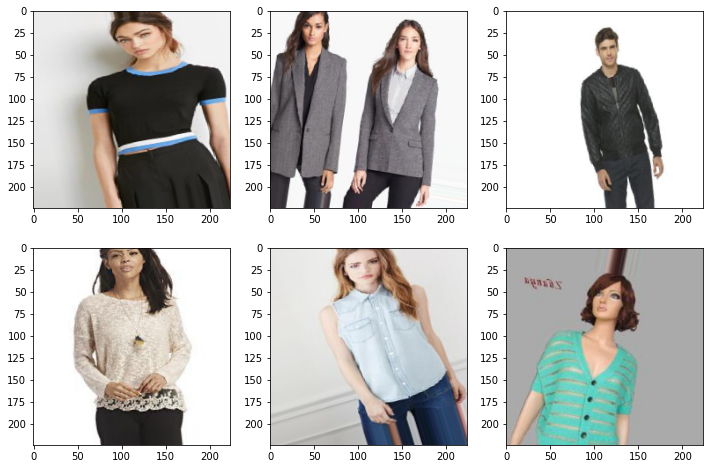

In [ ]:
images, labels = train_generator.next()
fig = plt.figure(figsize=(12, 8))
for i, image in enumerate(images[:6]):
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image/255)

## Training

In [ ]:
def create_model(model_type):
    if model_type == 'mobilenet_v2':
        pretrained_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
        preprocess_input = mobilenet_v2.preprocess_input
    elif model_type == 'nasnetmobile':
        pretrained_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=(224,224,3))
        preprocess_input = nasnet.preprocess_input
    pretrained_model.summary()
    pretrained_model.trainable = False
    model = Sequential()
    model.add(Input(shape=(224,224,3)))
    model.add(Lambda(preprocess_input))
    model.add(pretrained_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(46, activation='softmax'))
    return model

In [ ]:
initial_epochs = 10
initial_lr = 0.001

In [ ]:
#A function which evaluates a given model on the test data
def evaluate(model):
    labels = []
    predictions_prob = []
    for _ in tqdm(range(len(test_generator))):
        image, label = test_generator.next()
        labels.append(label)
        prediction = model.predict(image)
        predictions_prob.append(prediction)

    labels = np.argmax(np.array(labels), -1)
    predictions = np.argmax(np.array(predictions_prob), -1)
    predictions_prob = np.squeeze(np.array(predictions_prob))
    label_indices = list(test_generator.class_indices.values())
    label_names = list(test_generator.class_indices.keys())
    print(classification_report(labels, predictions, 
                            labels = label_indices, 
                            target_names = label_names))   
    print('Top 1 Accuracy', top_k_accuracy_score(labels, predictions_prob, k=1, labels = label_indices))
    print('Top 5 Accuracy', top_k_accuracy_score(labels, predictions_prob, k=5, labels = label_indices))

In [ ]:
#A function which computes the FLOPs and MACCs per layer for a given model
def get_flops_maccs(model, computations_dict):
    total_flops = 0
    total_maccs = 0
    
    for layer in model.layers:
        layer_name = layer.__class__.__name__
        if  layer_name == 'Conv2D' or layer_name == 'DepthwiseConv2D':
            weights_shape = layer.get_weights()[0].shape
            output_dim = 3 if layer.__class__.__name__ == 'Conv2D' else 2
            input_dim = 2 if output_dim == 3 else 3
            output_shape_maccs = weights_shape[output_dim] * layer.output_shape[2] ** 2   
            bias_maccs = output_shape_maccs * (1 if len(layer.get_weights()) > 0 else 0)

            maccs = output_shape_maccs * weights_shape[1]**2 * weights_shape[input_dim]
            flops =  2 * maccs
            
            flops += bias_maccs
            maccs += bias_maccs
            total_flops += flops 
            total_maccs += maccs
            
            computations_dict[layer.name] = (flops / 10 ** 6, maccs / 10 ** 6)
            
        elif layer.__class__.__name__ == 'SeparableConv2D':
            #separable
            weights_shape = layer.get_weights()[0].shape
            output_shape_maccs = (weights_shape[2] * (layer.output_shape[2] ** 2))    
            maccs = output_shape_maccs * weights_shape[1]**2 * weights_shape[3]

            #1x1 conv
            weights_shape = layer.get_weights()[1].shape
            output_shape_maccs = (weights_shape[3] * (layer.output_shape[2] ** 2))   
            maccs += output_shape_maccs * weights_shape[1]**2 * weights_shape[2]
            bias_maccs = output_shape_maccs * (1 if len(layer.get_weights()) > 2 else 0)

            flops =  2 * maccs
            total_flops += flops + bias_maccs
            total_maccs += maccs + bias_maccs
            
            computations_dict[layer.name] = (flops / 10 ** 6, maccs / 10 ** 6)

        elif layer_name == 'Dense':
            output_shape_maccs = layer.output_shape[1]

            bias_maccs = output_shape_maccs * (1 if len(layer.get_weights()) > 0 else 0)

            maccs = output_shape_maccs * layer.input_shape[1] 
            flops = 2 * maccs

            flops += bias_maccs
            maccs += bias_maccs
            total_flops += flops 
            total_maccs += maccs
            computations_dict[layer.name] = (flops / 10 ** 6, maccs / 10 ** 6)
        
        elif layer.__class__.__name__ == 'Functional':
            flops, maccs = get_flops_maccs(layer, computations_dict)
            total_flops += flops 
            total_maccs += maccs
        
        
    return total_flops, total_maccs

In [ ]:
def plot_history(acc, val_acc, loss, val_loss, finetuned=False):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    if finetuned:
        plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 3.0])
    if finetuned:
        plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

### MobileNet V2 

In [ ]:
mobilenet_v2_model = create_model('mobilenet_v2')
# compile model
mobilenet_v2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
mobilenet_v2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 46)                58926     
Total params: 2,316,910
Trainable params: 58,926
Non-trainable params: 2,257,984
_________________________________________________________________


#### Training the last dense layer

In [ ]:
history = mobilenet_v2_model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator,
                    verbose=1,
                    class_weight = class_weights)

Epoch 1/10
733/733 [==============================] - 248s 333ms/step - loss: 4.4434 - accuracy: 0.1820 - val_loss: 2.8903 - val_accuracy: 0.1930
Epoch 2/10
733/733 [==============================] - 231s 316ms/step - loss: 1.9114 - accuracy: 0.2840 - val_loss: 2.2986 - val_accuracy: 0.3136
Epoch 3/10
733/733 [==============================] - 231s 314ms/step - loss: 1.5704 - accuracy: 0.3181 - val_loss: 2.4943 - val_accuracy: 0.2841
Epoch 4/10
733/733 [==============================] - 233s 317ms/step - loss: 1.4651 - accuracy: 0.3443 - val_loss: 2.3262 - val_accuracy: 0.3217
Epoch 5/10
733/733 [==============================] - 233s 318ms/step - loss: 1.2970 - accuracy: 0.3682 - val_loss: 2.2024 - val_accuracy: 0.3740
Epoch 6/10
733/733 [==============================] - 230s 314ms/step - loss: 1.1885 - accuracy: 0.3883 - val_loss: 2.1476 - val_accuracy: 0.3709
Epoch 7/10
733/733 [==============================] - 231s 314ms/step - loss: 1.1313 - accuracy: 0.4096 - val_loss: 2.2327 -

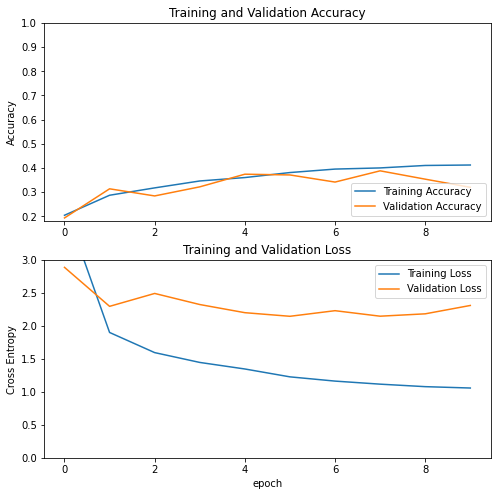

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_history(acc, val_acc, loss, val_loss)

In [ ]:
evaluate(mobilenet_v2_model)

100%|███████████████████████████████████████████████████████████████████████████████| 2893/2893 [01:52<00:00, 25.66it/s]

              precision    recall  f1-score   support

      Anorak       0.00      0.00      0.00         2
      Blazer       0.19      0.47      0.27        73
      Blouse       0.38      0.27      0.31       258
      Bomber       0.09      0.25      0.13         4
 Button-Down       0.00      0.00      0.00         2
      Caftan       0.00      0.00      0.00         2
      Capris       0.00      0.00      0.00         1
    Cardigan       0.36      0.21      0.27       127
      Chinos       0.17      0.33      0.22         3
        Coat       0.17      0.07      0.10        29
     Coverup       0.00      0.00      0.00         0
    Culottes       0.05      0.67      0.09         6
     Cutoffs       0.18      0.56      0.27        18
       Dress       0.90      0.30      0.45       688
     Flannel       0.20      0.40      0.27         5
     Gauchos       0.00      0.00      0.00         0
      Halter       0.00      0.00      0.00         0
      Henley       0.04    


/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/us

#### Finetuning the last 1/3 of the feature extractor along with the dense layer

In [ ]:
base_model = mobilenet_v2_model.layers[1]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
mobilenet_v2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=initial_lr/10), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = mobilenet_v2_model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator,
                         verbose=1,
                         class_weight = class_weights)

Epoch 10/20
733/733 [==============================] - 235s 317ms/step - loss: 2.5129 - accuracy: 0.2651 - val_loss: 2.3486 - val_accuracy: 0.3310
Epoch 11/20
733/733 [==============================] - 233s 318ms/step - loss: 1.2166 - accuracy: 0.3423 - val_loss: 2.0869 - val_accuracy: 0.3725
Epoch 12/20
733/733 [==============================] - 232s 317ms/step - loss: 1.0017 - accuracy: 0.4006 - val_loss: 2.1114 - val_accuracy: 0.3826
Epoch 13/20
733/733 [==============================] - 231s 315ms/step - loss: 0.8699 - accuracy: 0.4404 - val_loss: 1.9493 - val_accuracy: 0.4221
Epoch 14/20
733/733 [==============================] - 231s 315ms/step - loss: 0.8355 - accuracy: 0.4596 - val_loss: 1.9914 - val_accuracy: 0.4101
Epoch 15/20
733/733 [==============================] - 231s 316ms/step - loss: 0.7757 - accuracy: 0.4837 - val_loss: 2.0931 - val_accuracy: 0.4202
Epoch 16/20
733/733 [==============================] - 230s 313ms/step - loss: 0.7505 - accuracy: 0.5026 - val_loss: 2

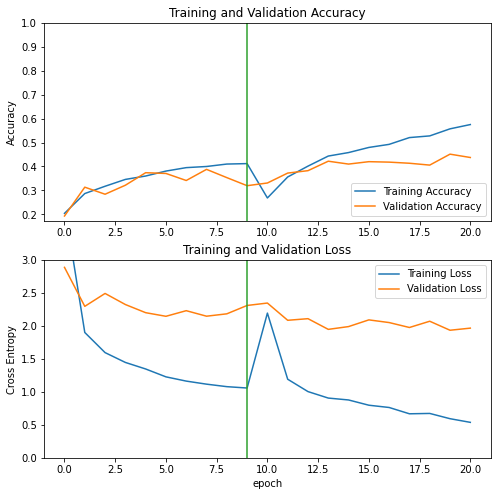

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plot_history(acc, val_acc, loss, val_loss, finetuned=True)

In [ ]:
evaluate(mobilenet_v2_model)

100%|███████████████████████████████████████████████████████████████████████████████| 2893/2893 [02:01<00:00, 23.75it/s]

              precision    recall  f1-score   support

      Anorak       0.00      0.00      0.00         2
      Blazer       0.35      0.45      0.40        73
      Blouse       0.47      0.25      0.33       258
      Bomber       0.00      0.00      0.00         4
 Button-Down       0.09      0.50      0.15         2
      Caftan       0.00      0.00      0.00         2
      Capris       0.50      1.00      0.67         1
    Cardigan       0.39      0.38      0.38       127
      Chinos       0.10      0.33      0.15         3
        Coat       0.22      0.41      0.29        29
     Coverup       0.00      0.00      0.00         0
    Culottes       0.20      0.17      0.18         6
     Cutoffs       0.15      0.39      0.22        18
       Dress       0.88      0.52      0.66       686
     Flannel       0.11      0.40      0.17         5
     Gauchos       0.00      0.00      0.00         0
      Halter       0.00      0.00      0.00         0
      Henley       0.07    


/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/us

#### Computing FLOPs

In [ ]:
computations_dict = {}
total_flops, total_maccs = get_flops_maccs(mobilenet_v2_model, computations_dict)
print('Total FLOPs(M)', total_flops / 10 ** 6)
print('Total MACCs(M)', total_maccs / 10 ** 6)
df = pd.DataFrame.from_dict(computations_dict,orient='index',columns=['FLOPs(M)', 'MACCs(M)'])
df = df.sort_values(by='FLOPs(M)', ascending=False)
df.head(10)

Total FLOPs(M) 605.784462
Total MACCs(M) 306.231310


,FLOPs(M),MACCs(M)
Conv_1,40.203520,20.133120
block_1_expand,39.739392,20.471808
block_16_project,30.121280,15.068480
block_3_expand,22.127616,11.289600
block_2_expand,22.127616,11.289600
Conv1,22.077440,11.239424
block_11_expand,21.788928,10.950912
block_12_expand,21.788928,10.950912
block_13_expand,21.788928,10.950912
block_2_project,21.751296,10.913280


#### Computing Receptive Field

In [ ]:
#https://github.com/google-research/receptive_field/pull/11/commits MobileNetv2 Support Pull Request
import receptive_field as rf
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import layers
g= tf.Graph()
with g.as_default():
    tf.keras.backend.set_learning_phase(0) # Disable BN learning.
    x = tf.keras.Input([None, None, 3], name='input_image')
    model = tf.keras.applications.MobileNetV2(input_tensor=x, weights=None,include_top=False)
    x = tf.keras.layers.MaxPooling2D()(model.output)
    x = tf.keras.layers.Conv2D(3, 3)(x)

graph_def = g.as_graph_def()
input_node = 'input_image'
for output_node in ["Conv_1/Conv2D", "conv2d/Conv2D", "block_10_project/Conv2D"]:
    (receptive_field_x, receptive_field_y, effective_stride_x,
    effective_stride_y, effective_padding_x, effective_padding_y) = (
            rf.compute_receptive_field_from_graph_def(graph_def, input_node,
                                                    output_node))
    print(receptive_field_x)

#### Saving model to disk

In [ ]:
mobilenet_v2_model.save('mobilenet_v2.h5')

### NasNetMobile

In [ ]:
nasnetmobile_model = create_model('nasnetmobile')
# compile model
nasnetmobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [ ]:
nasnetmobile_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1056)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                48622     
Total params: 4,318,338
Trainable params: 48,622
Non-trainable params: 4,269,716
_________________________________________________________________


#### Training the last dense layer

In [ ]:
history = nasnetmobile_model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator,
                    verbose=1,
                    class_weight = class_weights)

Epoch 1/10
733/733 [==============================] - 247s 323ms/step - loss: 3.6967 - accuracy: 0.1436 - val_loss: 2.8979 - val_accuracy: 0.2012
Epoch 2/10
733/733 [==============================] - 234s 319ms/step - loss: 2.3741 - accuracy: 0.2227 - val_loss: 2.6636 - val_accuracy: 0.2097
Epoch 3/10
733/733 [==============================] - 233s 317ms/step - loss: 1.8913 - accuracy: 0.2649 - val_loss: 2.4912 - val_accuracy: 0.2721
Epoch 4/10
733/733 [==============================] - 233s 318ms/step - loss: 1.7419 - accuracy: 0.2675 - val_loss: 2.5739 - val_accuracy: 0.2419
Epoch 5/10
733/733 [==============================] - 233s 317ms/step - loss: 1.7222 - accuracy: 0.2911 - val_loss: 2.3103 - val_accuracy: 0.3159
Epoch 6/10
733/733 [==============================] - 235s 320ms/step - loss: 1.6446 - accuracy: 0.3167 - val_loss: 2.3786 - val_accuracy: 0.2868
Epoch 7/10
733/733 [==============================] - 234s 319ms/step - loss: 1.4579 - accuracy: 0.3246 - val_loss: 2.5270 -

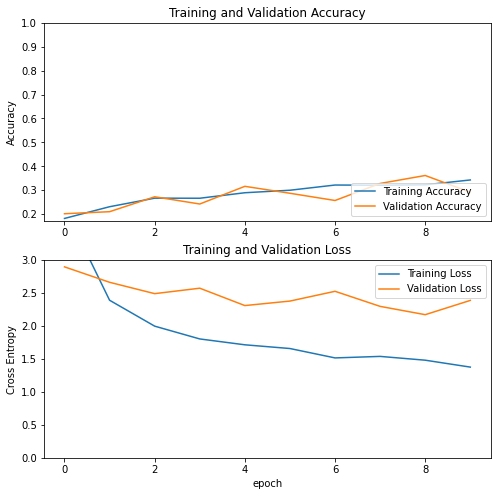

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_history(acc, val_acc, loss, val_loss)

In [ ]:
evaluate(nasnetmobile_model)

100%|███████████████████████████████████████████████████████████████████████████████| 2893/2893 [02:49<00:00, 17.03it/s]

              precision    recall  f1-score   support

      Anorak       0.00      0.00      0.00         2
      Blazer       0.30      0.44      0.35        73
      Blouse       0.33      0.14      0.20       258
      Bomber       0.00      0.00      0.00         4
 Button-Down       0.00      0.00      0.00         2
      Caftan       0.00      0.00      0.00         2
      Capris       0.00      0.00      0.00         1
    Cardigan       0.43      0.14      0.21       127
      Chinos       0.08      0.67      0.14         3
        Coat       0.24      0.14      0.17        29
     Coverup       0.00      0.00      0.00         0
    Culottes       0.18      0.33      0.24         6
     Cutoffs       0.11      0.56      0.19        18
       Dress       0.89      0.31      0.45       687
     Flannel       0.50      0.40      0.44         5
     Gauchos       0.00      0.00      0.00         0
      Halter       0.00      0.00      0.00         0
      Henley       0.11    


/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/us

#### Finetuning the last 1/3 of the feature extractor along with the dense layer

In [ ]:
base_model = nasnetmobile_model.layers[1]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  769


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
nasnetmobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=initial_lr/10), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = nasnetmobile_model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator,
                         verbose=1,
                         class_weight = class_weights)

Epoch 10/20
733/733 [==============================] - 354s 464ms/step - loss: 1.9227 - accuracy: 0.2763 - val_loss: 2.1667 - val_accuracy: 0.3047
Epoch 11/20
733/733 [==============================] - 364s 496ms/step - loss: 1.3134 - accuracy: 0.3236 - val_loss: 2.1547 - val_accuracy: 0.3322
Epoch 12/20
733/733 [==============================] - 356s 485ms/step - loss: 1.1204 - accuracy: 0.3827 - val_loss: 2.1475 - val_accuracy: 0.3368
Epoch 13/20
733/733 [==============================] - 355s 484ms/step - loss: 0.9498 - accuracy: 0.4113 - val_loss: 2.0851 - val_accuracy: 0.3581
Epoch 14/20
733/733 [==============================] - 355s 484ms/step - loss: 0.8435 - accuracy: 0.4462 - val_loss: 2.0545 - val_accuracy: 0.3702
Epoch 15/20
733/733 [==============================] - 355s 484ms/step - loss: 0.8408 - accuracy: 0.4549 - val_loss: 1.9861 - val_accuracy: 0.4058
Epoch 16/20
733/733 [==============================] - 355s 484ms/step - loss: 0.7370 - accuracy: 0.4819 - val_loss: 2

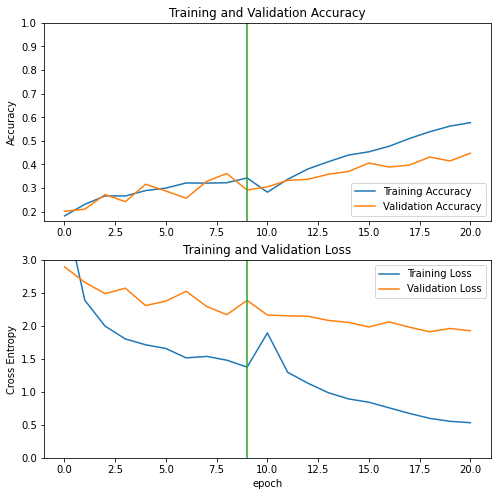

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plot_history(acc, val_acc, loss, val_loss, finetuned=True)

In [ ]:
evaluate(nasnetmobile_model)

100%|███████████████████████████████████████████████████████████████████████████████| 2893/2893 [03:22<00:00, 14.26it/s]

              precision    recall  f1-score   support

      Anorak       0.00      0.00      0.00         2
      Blazer       0.33      0.41      0.36        75
      Blouse       0.43      0.26      0.32       258
      Bomber       0.00      0.00      0.00         4
 Button-Down       0.00      0.00      0.00         1
      Caftan       0.00      0.00      0.00         2
      Capris       0.00      0.00      0.00         1
    Cardigan       0.40      0.34      0.37       125
      Chinos       0.00      0.00      0.00         2
        Coat       0.47      0.32      0.38        25
     Coverup       0.00      0.00      0.00         0
    Culottes       0.40      0.40      0.40         5
     Cutoffs       0.33      0.25      0.29        16
       Dress       0.85      0.59      0.69       684
     Flannel       0.22      0.33      0.27         6
     Gauchos       0.00      0.00      0.00         0
      Halter       0.00      0.00      0.00         0
      Henley       0.25    


/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/us

#### Computing FLOPs

In [ ]:
computations_dict = {}
total_flops, total_maccs = get_flops_maccs(nasnetmobile_model, computations_dict)
print('Total FLOPs(M)', total_flops / 10 ** 6)
print('Total MACCs(M)', total_maccs / 10 ** 6)
df = pd.DataFrame.from_dict(computations_dict,orient='index',columns=['FLOPs(M)', 'MACCs(M)'])
df = df.sort_values(by='FLOPs(M)', ascending=False)
df.head(10)

Total FLOPs(M) 1126.620537
Total MACCs(M) 563.989145


,FLOPs(M),MACCs(M)
reduction_conv_1_reduce_4,36.496768,18.282880
adjust_conv_projection_reduce_4,36.496768,18.282880
reduction_conv_1_reduce_8,36.462272,18.248384
adjust_conv_projection_reduce_8,36.462272,18.248384
stem_conv1,21.684960,11.039616
normal_conv_1_1,18.248384,9.141440
normal_conv_1_3,18.248384,9.141440
adjust_conv_projection_2,18.248384,9.141440
normal_conv_1_2,18.248384,9.141440
adjust_conv_projection_3,18.248384,9.141440


#### Saving model to disk

In [ ]:
nasnetmobile_model.save('nasnetmobile_model.h5')